In [1]:
import os
import pickle
import glob
import random
import time

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as st

import npc_lims
from npc_sessions import DynamicRoutingSession
# import npc_sessions.utils
from dynamic_routing_analysis import spike_utils, decoding_utils


In [2]:
all_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, is_annotated=True))

In [57]:
session_projects={
    'session':[],
    'project':[]
}
for ss in all_ephys_sessions:
    # session_projects['session'].append(str(ss.id+''))
    session_projects['session'].append(str(ss.id))
    session_projects['project'].append(str(ss.project))
# session_list=list(decoder_results.keys())
# for ss in session_list:
#     session=DynamicRoutingSession(ss)
#     session_projects['session'].append(session.project)

session_projects=pd.DataFrame(session_projects)
session_projects

,session,project
0,703882_2024-04-25,DynamicRouting
1,703882_2024-04-23,DynamicRouting
2,706401_2024-04-22,DynamicRouting
3,703882_2024-04-22,DynamicRouting
4,703880_2024-04-18,DynamicRouting
...,...,...
102,626791_2022-08-16,DynamicRouting
103,626791_2022-08-15,DynamicRouting
104,620264_2022-08-02,TempletonPilotSession
105,620263_2022-07-27,TempletonPilotSession


In [2]:
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units"
#loop through decoder results, append to dict
files=glob.glob(os.path.join(loadpath,'*_decoding_results*.pkl'))

In [3]:
files[40]

'\\\\allen\\programs\\mindscope\\workgroups\\templeton\\TTOC\\decoding results\\new_annotations\\linear_shift_20_units\\664851_2023-11-13_0_decoding_results_linear_shift_20_units.pkl'

In [6]:
decoder_results=pickle.load(open(files[40],'rb'))

In [10]:
session_id=list(decoder_results.keys())[0]

In [11]:
decoder_results[session_id].keys()

dict_keys(['shifts', 'middle_4_blocks', 'spikes_binsize', 'spikes_time_before', 'spikes_time_after', 'decoder_binsize', 'decoder_time_before', 'decoder_time_after', 'input_data_type', 'trials', 'results', 'areas'])

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23952\4003536124.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1)


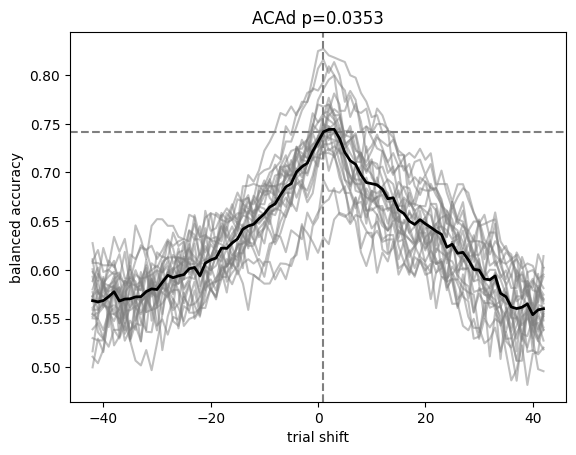

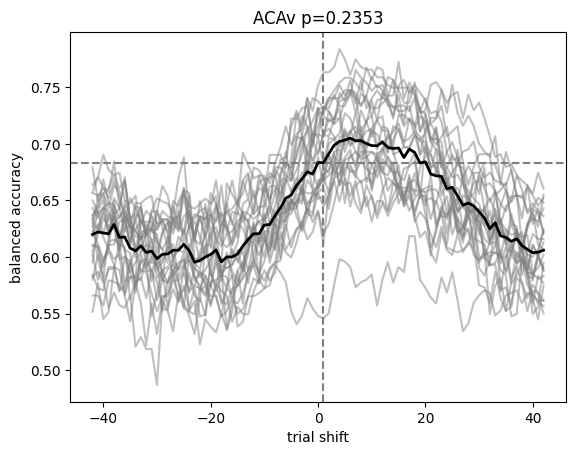

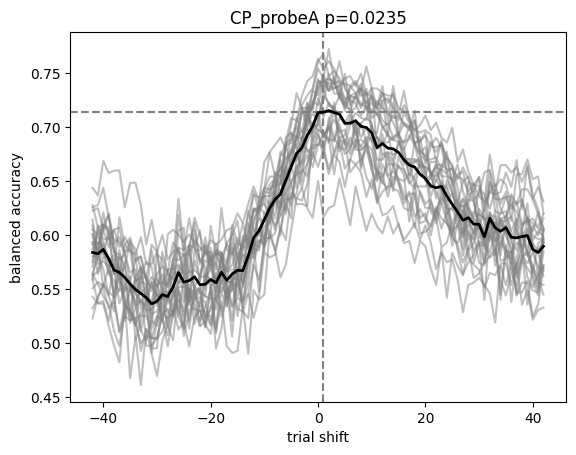

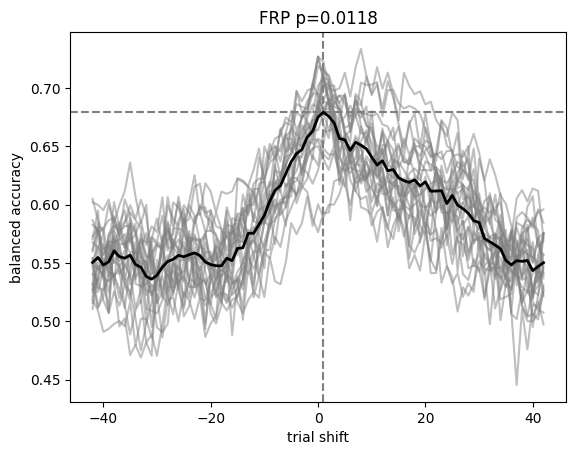

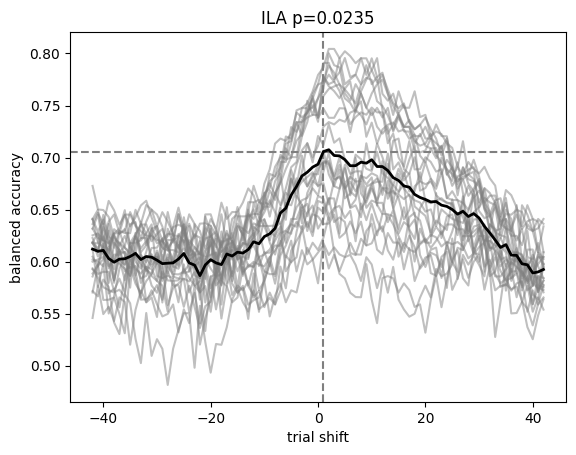

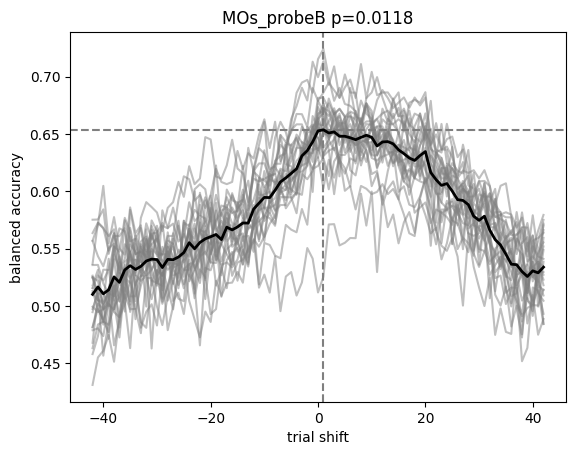

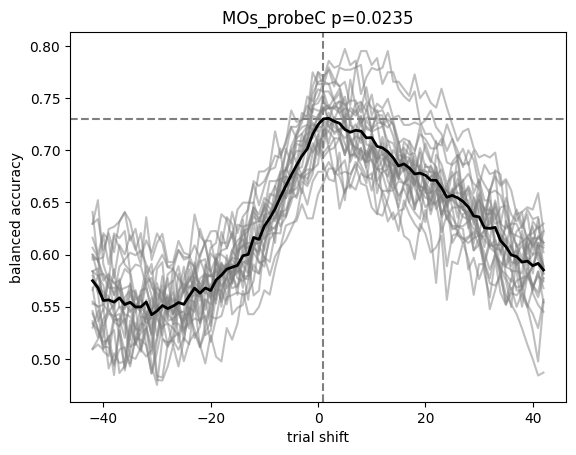

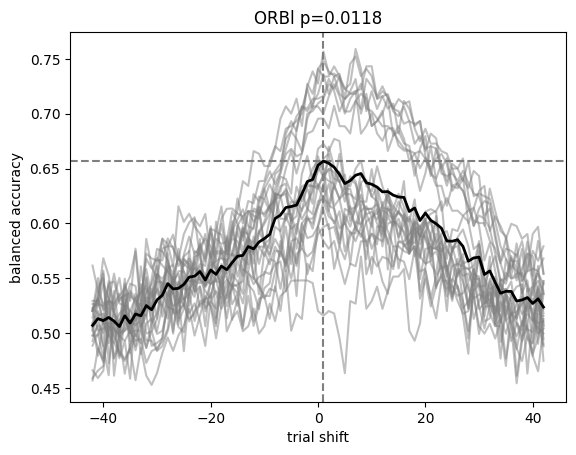

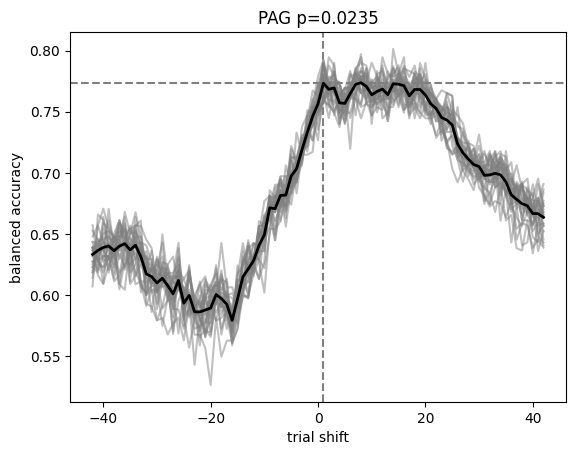

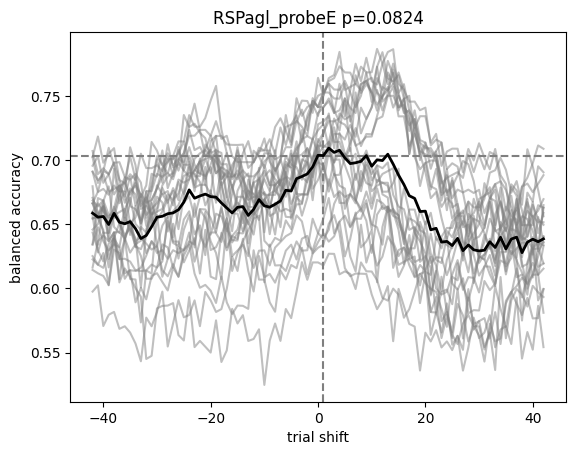

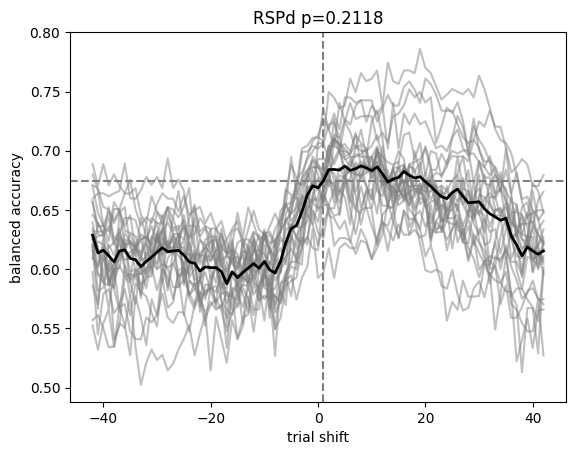

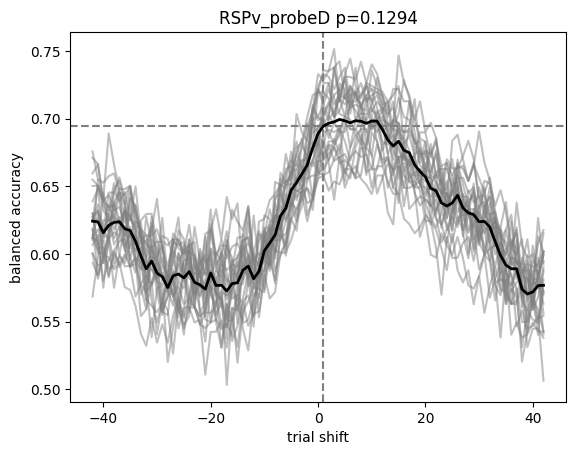

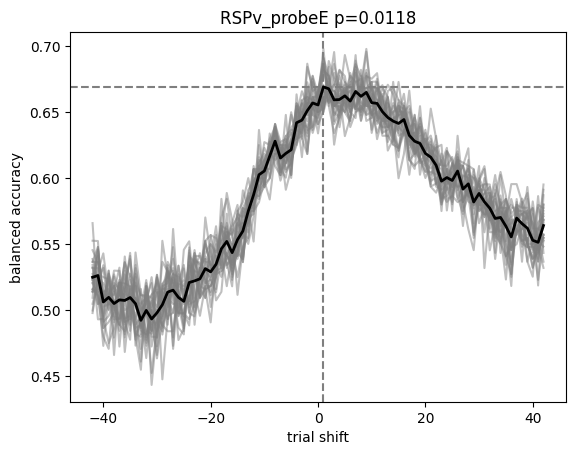

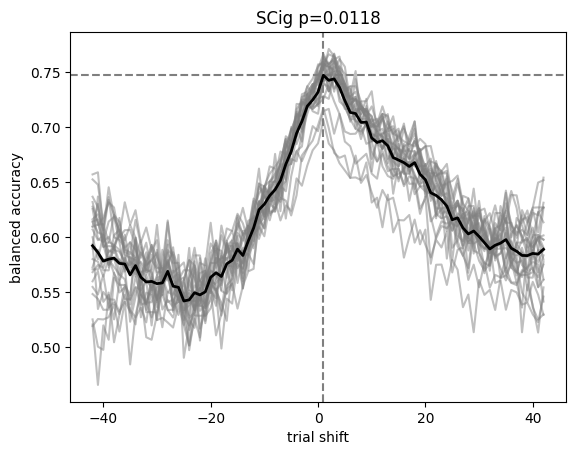

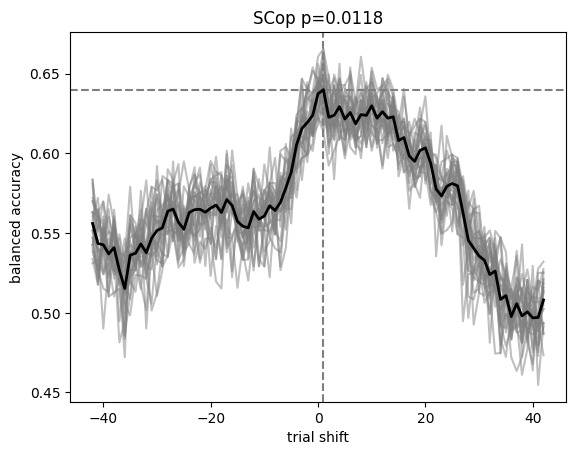

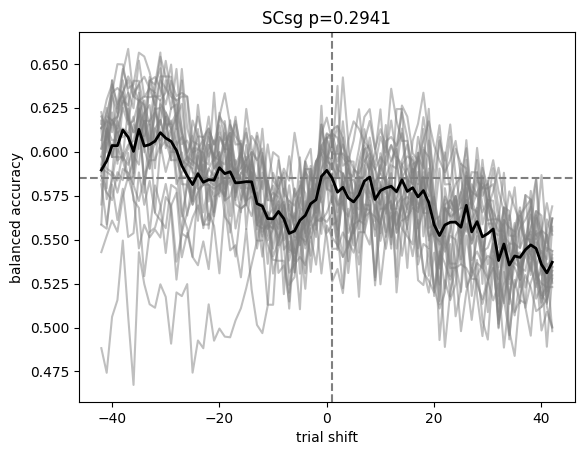

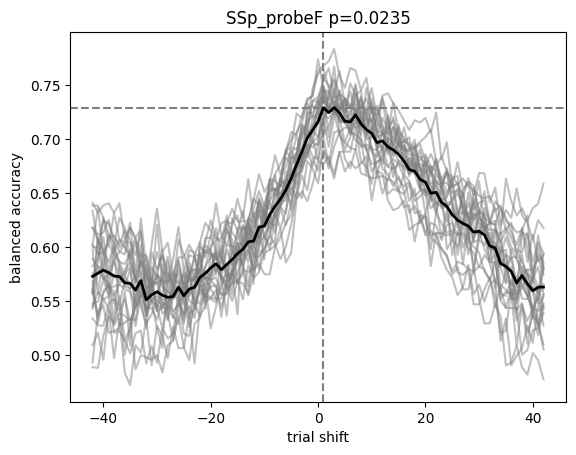

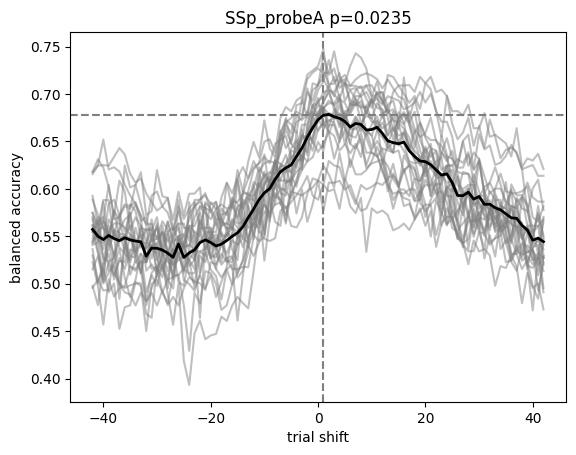

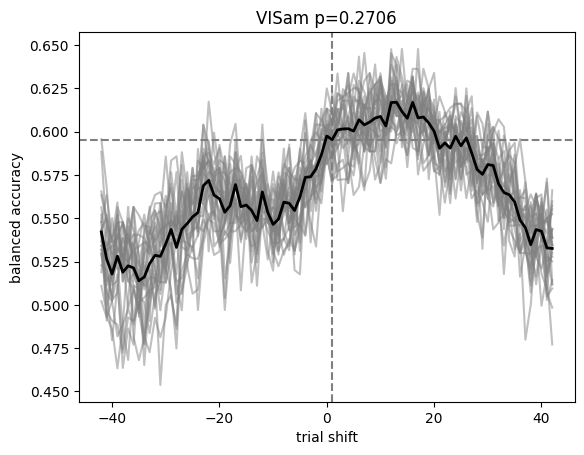

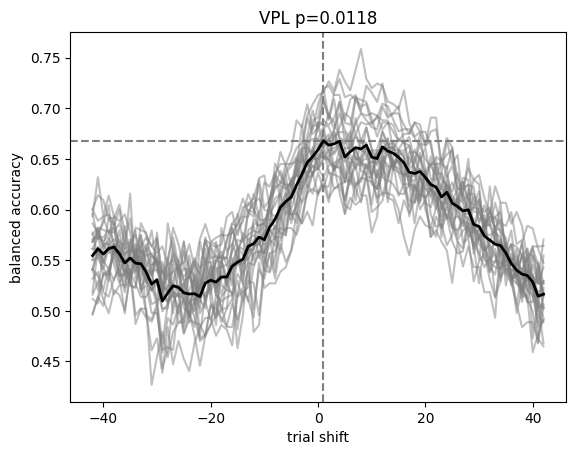

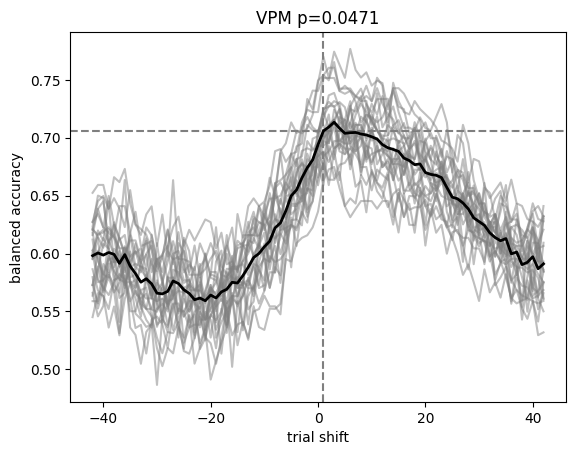

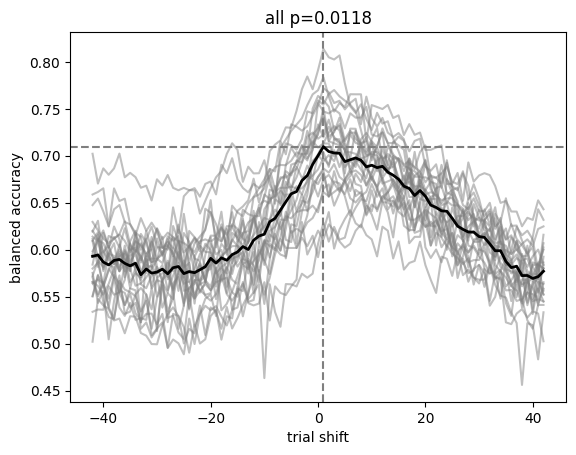

In [49]:
#load one file

use_half_shifts=False

# decoder_results=pickle.load(open(files[40],'rb'))
# session_id=list(decoder_results.keys())[0]

shifts=decoder_results[session_id]['shifts']
areas=decoder_results[session_id]['areas']
n_repeats=25

half_neg_shift=np.round(shifts.min()/2)
half_pos_shift=np.round(shifts.max()/2)

# half_shifts=np.arange(-half_neg_shift,half_pos_shift+1)
half_neg_shift_ind=np.where(shifts==half_neg_shift)[0][0]
half_pos_shift_ind=np.where(shifts==half_pos_shift)[0][0]
half_shift_inds=np.arange(half_neg_shift_ind,half_pos_shift_ind+1)

if use_half_shifts==False:
    half_shift_inds=np.arange(len(shifts))

bal_acc={}
for aa in areas:
    if aa in decoder_results[session_id]['results']:
        bal_acc[aa]=[]
        for rr in range(n_repeats):
            temp_bal_acc=[]
            for sh in half_shift_inds:
                if sh in list(decoder_results[session_id]['results'][aa]['shift'][rr].keys()):
                    temp_bal_acc.append(decoder_results[session_id]['results'][aa]['shift'][rr][sh]['balanced_accuracy'])
            bal_acc[aa].append(np.array(temp_bal_acc))
        bal_acc[aa]=np.vstack(bal_acc[aa])

for aa in areas:
    if aa in decoder_results[session_id]['results']:
        mean_acc=np.nanmean(bal_acc[aa],axis=0)
        
        true_acc=mean_acc[shifts[half_shift_inds]==1]
        pval=np.round(np.nanmean(mean_acc>=true_acc),decimals=4)
        
        fig,ax=plt.subplots(1,1)
        ax.axhline(true_acc,color='k',linestyle='--',alpha=0.5)
        ax.axvline(1,color='k',linestyle='--',alpha=0.5)
        # ax.plot(shifts,bal_acc[aa])
        ax.plot(shifts[half_shift_inds],bal_acc[aa].T,alpha=0.5,color='gray')
        ax.plot(shifts[half_shift_inds],mean_acc,color='k',linewidth=2)
        ax.set_xlabel('trial shift')
        ax.set_ylabel('balanced accuracy')
        # ax.set_title(aa+' n='+str(decoder_results[session_id]['results'][aa]['n_units'])+' p='+str(pval))
        ax.set_title(str(aa)+' p='+str(pval))



In [58]:
use_half_shifts=False

all_bal_acc={}
linear_shift_dict={
    'session_id':[],
    'project':[],
    'area':[],
    'true_accuracy':[],
    'null_accuracy_mean':[],
    'null_accuracy_median':[],
    'null_accuracy_std':[],
    'p_value':[],
    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'n_units':[],
    'probe':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
}

#loop through sessions
for file in files:
    decoder_results=pickle.load(open(file,'rb'))
    session_id=list(decoder_results.keys())[0]
    session_info=npc_lims.get_session_info(session_id)
    # session_id=str(session_info.id[:])
    try:
        performance=pd.read_parquet(
                    npc_lims.get_cache_path('performance',session_info.id,version='any')
                )
    except:
        continue

    if session_info.is_annotated==False:
        continue

    all_bal_acc[session_id]={}

    shifts=decoder_results[session_id]['shifts']
    #extract results according to the trial shift
    half_neg_shift=np.round(shifts.min()/2)
    half_pos_shift=np.round(shifts.max()/2)
    # half_shifts=np.arange(-half_neg_shift,half_pos_shift+1)
    half_neg_shift_ind=np.where(shifts==half_neg_shift)[0][0]
    half_pos_shift_ind=np.where(shifts==half_pos_shift)[0][0]
    half_shift_inds=np.arange(half_neg_shift_ind,half_pos_shift_ind+1)

    all_bal_acc[session_id]['shifts']=shifts
    all_bal_acc[session_id]['half_shift_inds']=half_shift_inds
    if use_half_shifts:
        half_shifts=shifts[half_shift_inds]
    else:
        half_shifts=shifts

    half_shift_inds=np.arange(len(half_shifts))
    
    areas=decoder_results[session_id]['areas']

    #save balanced accuracy by shift
    for aa in areas:
        if aa in decoder_results[session_id]['results']:
            # if use_half_shifts==False:
            #     half_shift_inds=np.asarray(list(decoder_results[session_id]['results'][aa]['shift'].keys()))
            #     half_shifts=shifts[half_shift_inds]
            all_bal_acc[session_id][aa]=[]
            for rr in range(n_repeats):
                temp_bal_acc=[]
                for sh in half_shift_inds:
                    if sh in list(decoder_results[session_id]['results'][aa]['shift'][rr].keys()):
                        temp_bal_acc.append(decoder_results[session_id]['results'][aa]['shift'][rr][sh]['balanced_accuracy'])
                all_bal_acc[session_id][aa].append(np.array(temp_bal_acc))
            all_bal_acc[session_id][aa]=np.vstack(all_bal_acc[session_id][aa])
            all_bal_acc[session_id][aa]=np.nanmean(all_bal_acc[session_id][aa],axis=0)

            if type(aa)==str:
                if '_probe' in aa:
                    area_name=aa.split('_probe')[0]
                    probe_name=aa.split('_probe')[1]
                else:
                    area_name=aa
                    probe_name=''
            else:
                area_name=aa
            
            true_acc_ind=np.where(half_shifts==1)[0][0]
            null_acc_ind=np.where(half_shifts!=1)[0]
            true_accuracy=all_bal_acc[session_id][aa][true_acc_ind]
            null_accuracy_mean=np.mean(all_bal_acc[session_id][aa][null_acc_ind])
            null_accuracy_median=np.median(all_bal_acc[session_id][aa][null_acc_ind])
            null_accuracy_std=np.std(all_bal_acc[session_id][aa][null_acc_ind])
            p_value=np.mean(all_bal_acc[session_id][aa][null_acc_ind]>=true_accuracy)

            #make big dict/dataframe for this:
            #save true decoding, mean/median null decoding, and p value for each area/probe
            linear_shift_dict['session_id'].append(session_id)
            linear_shift_dict['project'].append(session_projects.query('session==@session_id')['project'].values[0])
            linear_shift_dict['area'].append(area_name)
            linear_shift_dict['true_accuracy'].append(true_accuracy)
            linear_shift_dict['null_accuracy_mean'].append(null_accuracy_mean)
            linear_shift_dict['null_accuracy_median'].append(null_accuracy_median)
            linear_shift_dict['null_accuracy_std'].append(null_accuracy_std)
            linear_shift_dict['p_value'].append(p_value)

            linear_shift_dict['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
            linear_shift_dict['n_good_blocks'].append(np.sum(performance['cross_modal_dprime']>=1.0))

            # 'ccf_ap_mean', 'ccf_dv_mean', 'ccf_ml_mean'
            if 'ccf_ap_mean' in decoder_results[session_id]['results'][aa].keys():
                linear_shift_dict['ccf_ap_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ap_mean'])
                linear_shift_dict['ccf_dv_mean'].append(decoder_results[session_id]['results'][aa]['ccf_dv_mean'])
                linear_shift_dict['ccf_ml_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ml_mean'])
                linear_shift_dict['n_units'].append(decoder_results[session_id]['results'][aa]['n_units'])
                linear_shift_dict['probe'].append(probe_name)
            else:
                linear_shift_dict['ccf_ap_mean'].append(np.nan)
                linear_shift_dict['ccf_dv_mean'].append(np.nan)
                linear_shift_dict['ccf_ml_mean'].append(np.nan)
                linear_shift_dict['n_units'].append(np.nan)
                linear_shift_dict['probe'].append(np.nan)

    
linear_shift_df=pd.DataFrame(linear_shift_dict)
linear_shift_df.to_csv(os.path.join(loadpath,'combined','all_unit_linear_shift_use_more_trials.csv'))


In [73]:
#compare DR and Templeton:
p_threshold=0.05

DR_linear_shift_df=linear_shift_df.query('project=="DynamicRouting" and cross_modal_dprime>=1.0')
#fraction significant
frac_sig_DR={
    'area':[],
    'frac_sig_DR':[],
    'n_expts_DR':[],
}
for area in DR_linear_shift_df['area'].unique():
    frac_sig_DR['area'].append(area)
    frac_sig_DR['frac_sig_DR'].append(np.mean(DR_linear_shift_df.query('area==@area')['p_value']<p_threshold))
    frac_sig_DR['n_expts_DR'].append(len(DR_linear_shift_df.query('area==@area')))
frac_sig_DR_df=pd.DataFrame(frac_sig_DR)
#diff from null
diff_from_null_DR={
    'area':[],
    'diff_from_null_mean_DR':[],
    'diff_from_null_median_DR':[],
    'true_accuracy_DR':[],
    'null_median_DR':[],
    'n_expts_DR':[],
}
for area in DR_linear_shift_df['area'].unique():
    diff_from_null_DR['area'].append(area)
    diff_from_null_DR['diff_from_null_mean_DR'].append((DR_linear_shift_df.query('area==@area')['true_accuracy']-
                                                 DR_linear_shift_df.query('area==@area')['null_accuracy_mean']).mean())
    diff_from_null_DR['diff_from_null_median_DR'].append((DR_linear_shift_df.query('area==@area')['true_accuracy']-
                                                    DR_linear_shift_df.query('area==@area')['null_accuracy_median']).median())
    diff_from_null_DR['true_accuracy_DR'].append(DR_linear_shift_df.query('area==@area')['true_accuracy'].median())
    diff_from_null_DR['null_median_DR'].append(DR_linear_shift_df.query('area==@area')['null_accuracy_median'].median())
    diff_from_null_DR['n_expts_DR'].append(len(DR_linear_shift_df.query('area==@area')))

diff_from_null_DR_df=pd.DataFrame(diff_from_null_DR)
diff_from_null_DR_df


Templeton_linear_shift_df=linear_shift_df.query('project.str.contains("Templeton")')
#fraction significant
frac_sig_Templ={
    'area':[],
    'frac_sig_Templ':[],
    'n_expts_Templ':[],
}
for area in Templeton_linear_shift_df['area'].unique():
    frac_sig_Templ['area'].append(area)
    frac_sig_Templ['frac_sig_Templ'].append(np.mean(Templeton_linear_shift_df.query('area==@area')['p_value']<p_threshold))
    frac_sig_Templ['n_expts_Templ'].append(len(Templeton_linear_shift_df.query('area==@area')))
frac_sig_Templ_df=pd.DataFrame(frac_sig_Templ)
#diff from null
diff_from_null_Templ={
    'area':[],
    'diff_from_null_mean_Templ':[],
    'diff_from_null_median_Templ':[],
    'true_accuracy_Templ':[],
    'null_median_Templ':[],
    'n_expts_Templ':[],
}
for area in Templeton_linear_shift_df['area'].unique():
    diff_from_null_Templ['area'].append(area)
    diff_from_null_Templ['diff_from_null_mean_Templ'].append((Templeton_linear_shift_df.query('area==@area')['true_accuracy']-
                                                 Templeton_linear_shift_df.query('area==@area')['null_accuracy_mean']).mean())
    diff_from_null_Templ['diff_from_null_median_Templ'].append((Templeton_linear_shift_df.query('area==@area')['true_accuracy']-
                                                    Templeton_linear_shift_df.query('area==@area')['null_accuracy_median']).median())
    diff_from_null_Templ['true_accuracy_Templ'].append(Templeton_linear_shift_df.query('area==@area')['true_accuracy'].median())
    diff_from_null_Templ['null_median_Templ'].append(Templeton_linear_shift_df.query('area==@area')['null_accuracy_median'].median())
    diff_from_null_Templ['n_expts_Templ'].append(len(Templeton_linear_shift_df.query('area==@area')))
diff_from_null_Templ_df=pd.DataFrame(diff_from_null_Templ)


all_frac_sig_df=pd.merge(frac_sig_DR_df,frac_sig_Templ_df,on='area',how='outer')
all_diff_from_null_df=pd.merge(diff_from_null_DR_df,diff_from_null_Templ_df,on='area',how='outer')

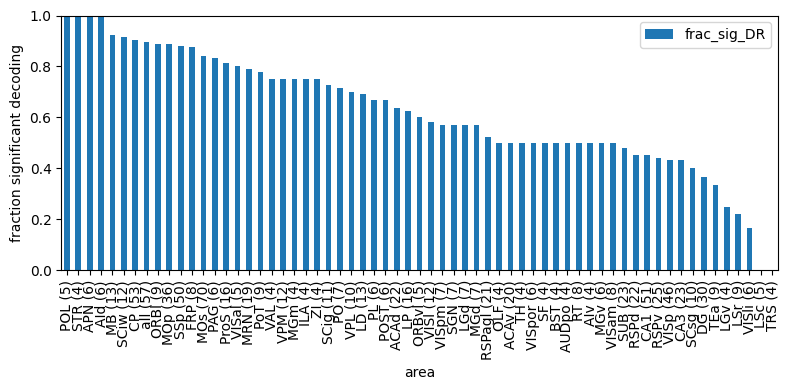

In [74]:
#barplot sorted by fraction significant
min_n_expts=4

plot_DR_frac_sig_df=frac_sig_DR_df.query('n_expts_DR>=@min_n_expts').sort_values('frac_sig_DR',ascending=False)
fig,ax=plt.subplots(1,1,figsize=(8,4))
plot_DR_frac_sig_df.plot.bar(x='area',y=['frac_sig_DR'],ax=ax)
ax.set_ylabel('fraction significant decoding')

area_labels=[]
for i in range(plot_DR_frac_sig_df.shape[0]):
    area_labels.append(plot_DR_frac_sig_df['area'].iloc[i]+' ('+str(plot_DR_frac_sig_df['n_expts_DR'].iloc[i])+')')
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylim([0,1])
fig.tight_layout()

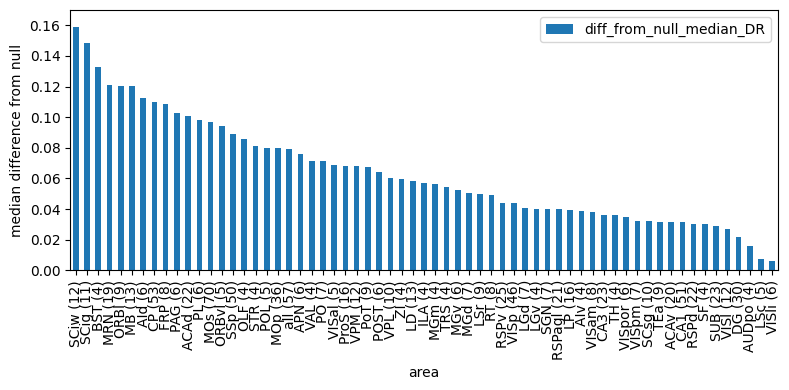

In [75]:
#barplot sorted by DR diff from median
min_n_expts=4

plot_DR_diff_from_null_df=diff_from_null_DR_df.query('n_expts_DR>=@min_n_expts').sort_values('diff_from_null_median_DR',ascending=False)
fig,ax=plt.subplots(1,1,figsize=(8,4))
plot_DR_diff_from_null_df.plot.bar(x='area',y=['diff_from_null_median_DR'],ax=ax)

ax.set_ylabel('median difference from null')
area_labels=[]
for i in range(plot_DR_diff_from_null_df.shape[0]):
    area_labels.append(plot_DR_diff_from_null_df['area'].iloc[i]+' ('+str(plot_DR_diff_from_null_df['n_expts_DR'].iloc[i])+')')
ax.set_xticklabels(area_labels,rotation=90,ha='center')

ax.set_ylim([0,0.17])
fig.tight_layout()



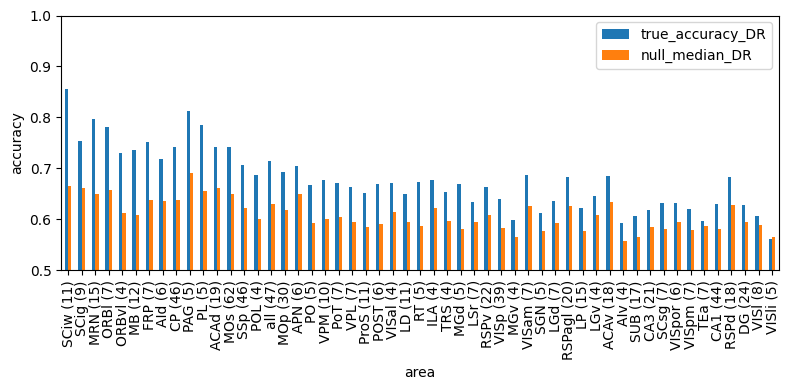

In [70]:
#plot true accuracy and null median on same barplot

min_n_expts=4

plot_DR_diff_from_null_df=diff_from_null_DR_df.query('n_expts_DR>=@min_n_expts').sort_values('diff_from_null_median_DR',ascending=False)
fig,ax=plt.subplots(1,1,figsize=(8,4))
plot_DR_diff_from_null_df.plot.bar(x='area',y=['true_accuracy_DR','null_median_DR'],ax=ax)

ax.set_ylabel('accuracy')
area_labels=[]
for i in range(plot_DR_diff_from_null_df.shape[0]):
    area_labels.append(plot_DR_diff_from_null_df['area'].iloc[i]+' ('+str(plot_DR_diff_from_null_df['n_expts_DR'].iloc[i])+')')

ax.set_xticklabels(area_labels,rotation=90,ha='center')

ax.set_ylim([0.5,1.0])
fig.tight_layout()

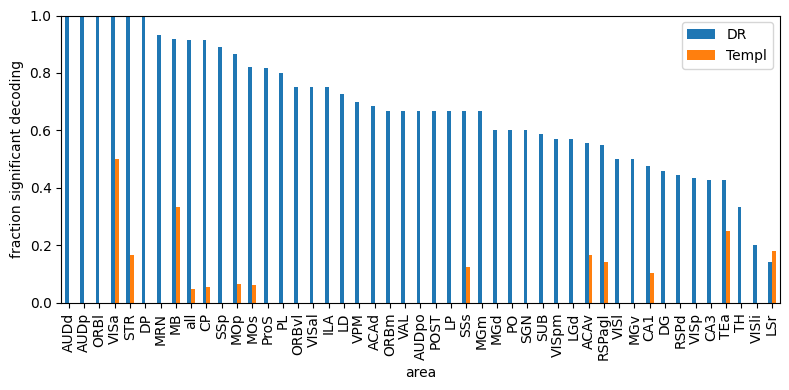

In [71]:
#barplot sorted by fraction significant
min_n_expts=2

plot_all_frac_sig_df=all_frac_sig_df.query('n_expts_DR>=@min_n_expts and n_expts_Templ>=@min_n_expts').sort_values('frac_sig_DR',ascending=False)
fig,ax=plt.subplots(1,1,figsize=(8,4))
plot_all_frac_sig_df.plot.bar(x='area',y=['frac_sig_DR','frac_sig_Templ'],ax=ax)
ax.set_ylabel('fraction significant decoding')
# ax.set_xlabel('area')
ax.legend(['DR','Templ'])
ax.set_ylim([0,1])
fig.tight_layout()

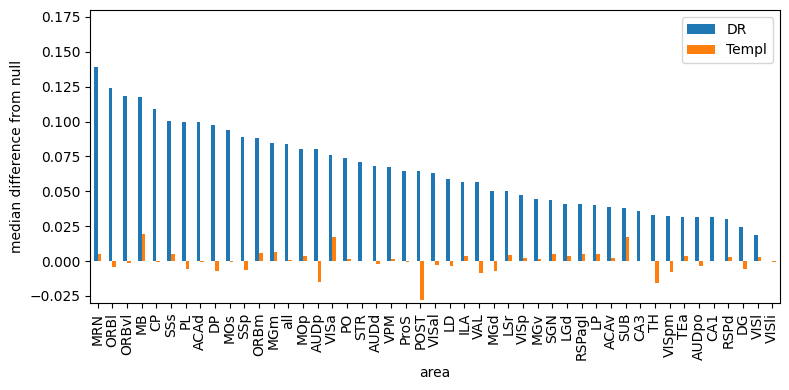

In [72]:
#barplot sorted by DR diff from median
min_n_expts=2

plot_all_diff_from_null_df=all_diff_from_null_df.query('n_expts_DR>=@min_n_expts and n_expts_Templ>=@min_n_expts').sort_values('diff_from_null_median_DR',ascending=False)
fig,ax=plt.subplots(1,1,figsize=(8,4))
plot_all_diff_from_null_df.plot.bar(x='area',y=['diff_from_null_median_DR','diff_from_null_median_Templ'],ax=ax)

ax.set_ylabel('median difference from null')
# ax.set_xlabel('area')
ax.legend(['DR','Templ'])

ax.set_ylim([-0.03,0.18])
fig.tight_layout()

